In [1]:
import pyross.tsi as pyrosstsi 
import numpy as np
import scipy
from scipy import special
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
T = 15                                       # Longest  infectious duration
Td = 5                                       # Doubling time in linear growth regime
Tf = 150                                     # Duration of simulation

tsi  = np.array([0,   3,    5,   10,   T])   # Time since infection (days)
beta = np.array([0,   0.5,  1,   .5,   0])   # Mean infectiousness 

M = 2                                        # Number of age groups to model
Ni = 10**6*np.ones(M)                        # Number of people in each age group
Np = sum(Ni)                                 # Total population size

#how many 'stages' to resolve in time since infection?
Nk = 10

#define a time-dependent contact matrix.
#variations on timescale less than T/Nk may not be resolved.
def contactMatrix(t):
    if t > 300 and t < 45:
        return 0.1*np.array([[4, 1],[1, 2]])
    else:
        return np.array([[4, 1],[1, 2]]); 

subclasses = ['Recovered', 'Hospitalized', 'Mortality']  
pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
pD = 1-pR;             #probability of death for each age class

#prepare for a linear interpolating function evaluated at times:
tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])   

phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)

#combine hospital in/out to a single function for net change in hospitalized cases
phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))

#normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
phiR, phiD  = phiR/np.trapz(phiR,tsi_sc),  phiD/np.trapz(phiD,tsi_sc)

#group them all together for later processing
phi_alpha, p_alpha = np.array([phiR, phiH, phiD]), np.array([pR, pH, pD])

In [3]:
parameters = {'M':M, 'Ni':Ni, 'Nc':len(subclasses), 'Nk':Nk, 'Tf':Tf, 'Tc':(T/2), 'T':T, 'Td':Td,
              'tsi':tsi,'beta':beta,'tsi_sc':tsi_sc, 'phi_alpha':phi_alpha, 'p_alpha':p_alpha, 
              'contactMatrix':contactMatrix}

model = pyrosstsi.deterministic.Simulator(parameters)
IC    = model.get_IC()
data  = model.simulate(IC)

## Plot the results

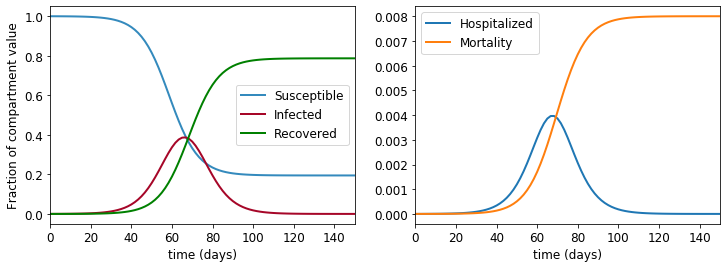

In [4]:
#unpack and rescale simulation output
t = data['t']; S_t = data['S_t']; I_t = data['I_t']; Ic_t = data['Ic_t'] 

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(t,np.sum(S_t,0), color="#348ABD", lw=2, label = 'Susceptible')           #all susceptible
plt.plot(t,np.sum(I_t,0), color="#A60628", lw=2, label = 'Infected')              #all Infected
plt.plot(t,np.sum(Ic_t[0,:,:],0), color='green', lw=2, label = 'Recovered')    #all Recovered
plt.xlabel('time (days)');       plt.xlim(0,Tf);  
plt.ylabel('Fraction of compartment value');   plt.legend()

plt.subplot(122) 
for i in (1 + np.arange(len(subclasses)-1)):
    plt.plot(t,np.sum(Ic_t[i,:,:],0), lw=2, label = subclasses[i])
plt.legend(); plt.xlabel('time (days)'); plt.xlabel('time (days)'); plt.xlim(0,Tf);   

## Introduce Uncertainty into $\beta(s)$ and the doubling time $T_d$

Here, we suppose that uncertainty in the overall growth rate (e.g. the doubling time) is decoupled from uncertainty in the time since infection at which most transmission occurs.

As a first approximation, we assume that all inputs to beta(s) (e.g. function values and time steps) have uncertainties that are independent and log-normal distributed with the same overall uncertainty.

In [5]:
#define a routine to sample log-normal distribution with
#mean xbar and standard deviation (relative to mean) var
def get_lognormal_rand(xbar,var):
    if xbar == 0:
        return 0
    s2 = np.log(1 + var**2)
    mu = np.log(xbar) - s2/2
    Phi = np.random.rand(1)
    return np.exp(scipy.special.erfinv(2*Phi - 1)*np.sqrt(2*s2) + mu)

#define a routine to return a randomized interpolating function beta(s)
#given an 'overall' uncertainty estimate
def get_random_beta(tsi,beta,var):
    beta_rand = np.copy(beta)
    tsi_rand = np.copy(tsi)
    for i in range(len(beta)):
        beta_rand[i] = get_lognormal_rand(beta[i],var)
    for i in np.arange(len(tsi) -2 ):
        tsi_rand[i+1] = tsi_rand[i] + get_lognormal_rand(tsi[i+1] - tsi[i],var)
    tsi_rand[len(tsi)-1] = tsi[len(tsi)-1]
    return tsi_rand, beta_rand

#Define a routine to take in parameters and uncertainty estimates and output a forecast
def get_forecast(var_Td, var_tsi, nf = 20):
    
    #initialize forecast containers
    nt = int(np.floor(Tf/T*(Nk-1))) + 1;
    Nc = len(subclasses)
    S_f = np.zeros((nf,M,nt))
    I_f = np.zeros((nf,M,nt))
    Ic_f = np.zeros((nf,Nc,M,nt))
    
    #initialze quartile containers
    S_q = np.zeros((3,M,nt))
    I_q = np.zeros((3,M,nt))
    Ic_q = np.zeros((3,Nc,M,nt))
    
    #loop over the prescribed number of forecasts
    for i in range(nf):
        #appropriately randomize beta(s) and doubling time:
        tsi_f, beta_f = get_random_beta(tsi,beta,var_tsi)
        Td_f = get_lognormal_rand(Td,var_Td)
        
        #update parameters list
        parameters['Td'] = Td_f; parameters['beta'] = beta_f; parameters['tsi'] = tsi_f
        
        #set up model, simulate, and collect data
        model = pyrosstsi.deterministic.Simulator(parameters)
        IC    = model.get_IC()
        data  = model.simulate(IC)
        
        #unpack data and save to forecast list:
        S_f[i,:,:] = data['S_t']; I_f[i,:,:] = data['I_t'];  Ic_f[i,:,:,:] = data['Ic_t']
    
    #unpack the time as well
    t = data['t']
    
    #loop through each timestep to find upper/middle/lower quartile to report
    for i in range(len(t)):
        for j in range(M):
            S_q[:,j,i]  = np.quantile( S_f[:,j,i],[1/4, 1/2, 3/4])
            I_q[:,j,i]  = np.quantile( I_f[:,j,i],[1/4, 1/2, 3/4])
            for k in range(Nc):
                Ic_q[:,k,j,i] = np.quantile(Ic_f[:,k,j,i],[1/4, 1/2, 3/4])
    
    #report quantiles
    return t, S_q, I_q, Ic_q
        

## Forecast with Uncertainty in both $T_d$ and $\beta(s)$:

Forecast returns upper/middle/lower quartiles of the projections

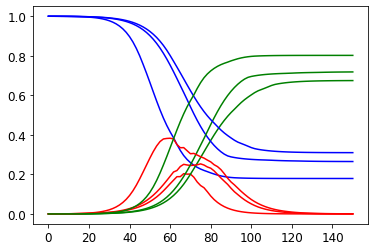

In [6]:
t,S_q, I_q, Ic_q = get_forecast(.2, .3)

plt.figure()
for i in range(3):
    plt.plot(t,np.sum(S_q[i,:,:],0),color = 'blue', label = 'Susceptible')
    plt.plot(t,np.sum(I_q[i,:,:],0),color = 'red', label = 'Infected')
    plt.plot(t,np.sum(Ic_q[i,0,:,:],0),color = 'green', label = 'Recovered')

    
    

## Forecast with Uncertainty in $\beta(s)$ only:

Here, we turn off uncertainty in the doubling time.  The breadth of the forecasting range narrows considerably -- knowing the 'shape' of $\beta(s)$ is far less important than knowing the doubling time.

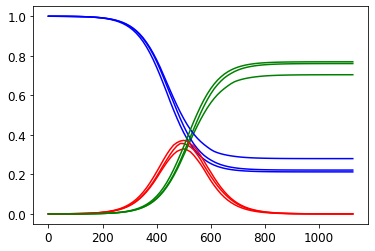

In [7]:
t,S_q, I_q, Ic_q = get_forecast(.0, .3)

plt.figure()
for i in range(3):
    plt.plot(t*T/2,np.sum(S_q[i,:,:],0),color = 'blue', label = 'Susceptible')
    plt.plot(t*T/2,np.sum(I_q[i,:,:],0),color = 'red', label = 'Infected')
    plt.plot(t*T/2,np.sum(Ic_q[i,0,:,:],0),color = 'green', label = 'Recovered')
